## Predictive Modeling (GMS) 

### Summary of Previous Stage (see Notebook 3; Preprocessing_Training_CompletionRangeFiltered)

Note that for this version, puzzles from the first solve period (2018) have been removed due to the volatility of times in that solve period, while the GMS presumably "learned the ropes" of digital solving. 

#### 2 Linear Regression "Benchmark" models were generated to predict GMS solve times on 15x15 (Mon-Sat) puzzles:
* 1) A "dummy" model, which simply uses mean of training data split to predict target feature -GMS's raw solve time (in min)
    * Root Mean Squared Error (RMSE) Training Set: 8.28;  Test Set: 8.09 
* 3) A univariate linear model using GMS's puzzle-day specific mean solve time across the entire sample as the sole predictive feature (ie, if predicting a Mon IS1 solve time, IS1 Mon mean across the entire sample is used to predict)
    * Root Mean Squared Error (RMSE) Training Set: 4.48(.37);  Test Set: 4.14
 
75%/25% Train/Test split was used for each of these Benchmark models

### High-Level Overview of Modeling

Four regression models are evaluated presently, across the entire sample of 15x15 puzzles solved by IS1. First is simply a Linear Regression Model. The subsequent three models are decision tree models: Random Forest, Gradient Boosting Regressor and HistGradient Boosting Regressor. The latter is an ensemble machine learning algorithm that is very fast (relative to standard gradient boosting models), and performs well on heterogenous data sets. Boosting, generally, refers to a class of ensemble learning algorithms that add tree models to an ensemble sequentially. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [2]:
# Ths is the file and analysis data range used for the main clay court analysis
#Note that 2018 was already filtered out prior to the data import here, though it was kept in to accrue retrospective stats on solver and constructor performance for puzzles 2019 and later
df = pd.read_csv('../data/df_for_modeling.csv')
df.head()

,P_Date,P_Date_str,DOW,GMST(m),GMS_pds_l10_dw,GMS_pds_l25_dw,GMS_pds_l10_stdev,GMS_pds_l25_stdev,GMST_Diff%_from_GMS_pds_l10_dw,GMS_per_constr_avg_past_diff_from_RPB,...,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay,overall_day_mean_GMST(m)
0,2024-02-03,2024-02-03,Saturday,22.583333,19.944848,21.907538,5.103116,4.545437,12.41,NaN,...,0,0,0,0,0,0,0,0,7.0,26.541479
1,2024-02-02,2024-02-02,Friday,18.783333,17.210909,17.334205,3.480521,2.455251,8.74,NaN,...,0,0,0,0,0,0,0,0,6.0,21.449373
2,2024-02-01,2024-02-01,Thursday,19.700000,15.780606,16.550718,2.244750,4.131868,22.09,7.74,...,0,0,0,0,0,0,0,0,5.0,20.709774
3,2024-01-31,2024-01-31,Wednesday,10.783333,11.621515,12.138103,2.338474,2.691352,-7.48,NaN,...,17,0,0,0,0,0,0,0,5.0,13.259712
4,2024-01-30,2024-01-30,Tuesday,7.383333,7.765758,7.783641,1.156256,1.306190,-5.05,-8.32,...,0,0,0,0,0,0,0,0,2.0,9.720614


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   P_Date                                 1596 non-null   object 
 1   P_Date_str                             1596 non-null   object 
 2   DOW                                    1596 non-null   object 
 3   GMST(m)                                1596 non-null   float64
 4   GMS_pds_l10_dw                         1595 non-null   float64
 5   GMS_pds_l25_dw                         1595 non-null   float64
 6   GMS_pds_l10_stdev                      1595 non-null   float64
 7   GMS_pds_l25_stdev                      1595 non-null   float64
 8   GMST_Diff%_from_GMS_pds_l10_dw         1595 non-null   float64
 9   GMS_per_constr_avg_past_diff_from_RPB  1071 non-null   float64
 10  GMS_per_constr_past_diff_from_RPB_ct   1596 non-null   float64
 11  GMS_

In [8]:
# Drop some columns that we don't want/need for modeling
df_filter = df.copy()
df_filter.drop(['P_Date','P_Date_str','DOW', 'GMST_Diff%_from_GMS_pds_l10_dw','GMS_per_constr_past_diff_from_RPB_ct','Constructors','overall_day_mean_GMST(m)','Uniclue','Duplicate_Answers','Unchecked_Sq','Quantum'],inplace=True,axis=1)

In [9]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   GMST(m)                                1596 non-null   float64
 1   GMS_pds_l10_dw                         1595 non-null   float64
 2   GMS_pds_l25_dw                         1595 non-null   float64
 3   GMS_pds_l10_stdev                      1595 non-null   float64
 4   GMS_pds_l25_stdev                      1595 non-null   float64
 5   GMS_per_constr_avg_past_diff_from_RPB  1071 non-null   float64
 6   GMS_pds_prior_solves_ct                1596 non-null   float64
 7   GMS_npds_prior_solves_ct               1596 non-null   float64
 8   DOW_num                                1596 non-null   float64
 9   Words                                  1596 non-null   int64  
 10  Blocks                                 1596 non-null   int64  
 11  Unus

In [10]:
#Move target feature to the front
col = df_filter.pop('GMST(m)')
df_filter.insert(0, col.name, col)

In [373]:
#Found a bad value in first modeling iteration, so correcting here
# df["Duplicate_Answers"].unique()
# df["Uniclue"].unique()
# df["Unchecked_Sq"].unique()
# df["Quantum"].unique()

array([0, 1], dtype=int64)

In [11]:
#Deep copy of this df_filter that is now pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given puzzle being predicted on. No data leakage!
df_model1 = df_filter.copy()

#df_model1 = df_model1[['IS1_ST(m)', 'Comp_Hr', 'Solve_day_phase', 'IS_per_sdp_avg_past_diff_from_RPB', 'DOW_num', 'IS_pds_l10_dw', 'IS_pds_l10_stdev', 'IS_per_constr_avg_past_diff_from_RPB', 'IS1_pds_prior_solves_ct', 'IS1_npds_prior_solves_ct', 'num_solves_l7', 'Words', 'Blocks', 'Unused_Letters', 'Stacks','Unique_Answers','Rebus_Count','Rebus_Unique','Cheater_Squares','AWL','Scrabble_Score','Scrabble_Avg','FITB','Cross_Ref_Clues','Scrabble_Illegal','Open_Squares','Freshness_Factor','Overall_Freshness%','Day_Freshness%','Duplicate_Clues','Circle_Count','Shade_Count','Unusual_Sym','Black_Square_Fill','Outside_Grid','Wordplay']]

#df_model1.drop(['IS_per_constr_avg_past_diff_from_RPB','Scrabble_Score', 'IS_pds_l10_dw', 'IS_pds_l10_stdev'],inplace=True,axis=1)

In [12]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   GMST(m)                                1596 non-null   float64
 1   GMS_pds_l10_dw                         1595 non-null   float64
 2   GMS_pds_l25_dw                         1595 non-null   float64
 3   GMS_pds_l10_stdev                      1595 non-null   float64
 4   GMS_pds_l25_stdev                      1595 non-null   float64
 5   GMS_per_constr_avg_past_diff_from_RPB  1071 non-null   float64
 6   GMS_pds_prior_solves_ct                1596 non-null   float64
 7   GMS_npds_prior_solves_ct               1596 non-null   float64
 8   DOW_num                                1596 non-null   float64
 9   Words                                  1596 non-null   int64  
 10  Blocks                                 1596 non-null   int64  
 11  Unus

In [389]:
df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [13]:
len(df_model1) * .75, len(df_model1) * .25

(1197.0, 399.0)

In [14]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='GMST(m)'), 
                                                    df_model1['GMST(m)'], test_size=0.25, 
                                                    random_state=47)

In [15]:
y_train.shape, y_test.shape

((1197,), (399,))

In [16]:
y_train

647      5.966667
106      7.950000
813     11.516667
851      5.916667
236     28.633333
          ...    
691     16.033333
584     14.350000
1288    13.133333
327      9.900000
1159    26.166667
Name: GMST(m), Length: 1197, dtype: float64

In [17]:
X_train.shape, X_test.shape

((1197, 33), (399, 33))

## Linear Model

In [18]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [19]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [20]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean','median'],
    'selectkbest__k': k
}


In [21]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [22]:
#Conduct grid search. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001B61577B820>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [23]:
#Best params from grid search
lr_grid_cv.best_params_

{'selectkbest__k': 12,
 'simpleimputer__strategy': 'median',
 'standardscaler': StandardScaler()}

### K Best Features Visualization

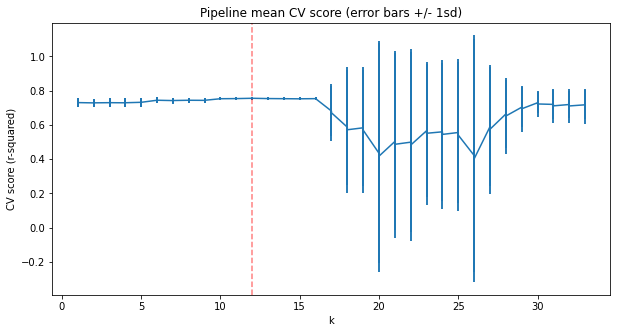

In [24]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Best Linear Model Performance Metrics

#### R-squared (COD)

In [25]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.7543355 , 0.75942684, 0.75474352, 0.7686621 , 0.74163676])

In [26]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.7557609425327607, 0.008745721251141314)

#### Mean Absolute Error (MAE)

In [27]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [28]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(2.8043319650789593, 0.1008135969079413)

In [29]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

2.6353625607859095

#### Mean Squared Error (MSE)

In [30]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [31]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(16.65535738724636, 2.0180700642455904)

In [32]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

13.682849944515244

#### Root Mean Square Error (RMSE)

In [33]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [34]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(4.074115345439753, 0.2386242638515228)

In [35]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

3.6990336500923107

### Best Linear Model Feature Importance

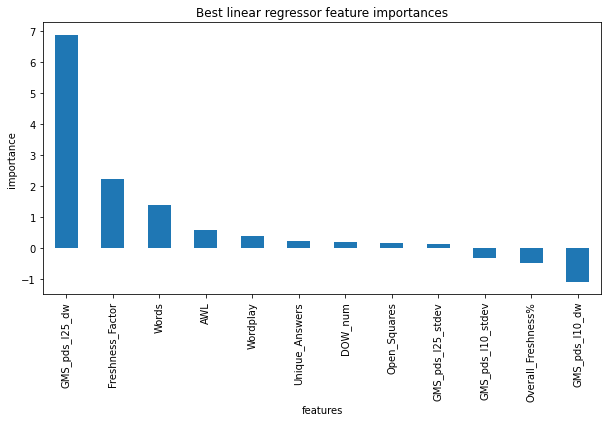

In [36]:
#Plot a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

## Random Forest Regression Model

### Random Forest Model: Hyperparameter Grid Search

In [37]:
#Define pipeline
RF_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [38]:
#Dict of available parameters for RF pipe
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'randomforestregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomf

In [39]:
#Define search grid parameters

#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
n_est = [400, 500, 600]

grid_params = {
        'randomforestregressor__n_estimators': n_est, 
        'randomforestregressor__max_features': [15, 20, 25],
        'randomforestregressor__max_depth': [5, 10, 15],
        'randomforestregressor__min_samples_split': [2, 3, 4],
        'randomforestregressor__min_samples_leaf': [15, 20, 25],
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean','median']}
grid_params

#These were the best hyperparams across 5 sampling space runs (see cell below)

{'randomforestregressor__n_estimators': [400, 500, 600],
 'randomforestregressor__max_features': [15, 20, 25],
 'randomforestregressor__max_depth': [5, 10, 15],
 'randomforestregressor__min_samples_split': [2, 3, 4],
 'randomforestregressor__min_samples_leaf': [15, 20, 25],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean', 'median']}

In [501]:
#First Pass
# {'randomforestregressor__n_estimators': [400, 500, 600],
#  'randomforestregressor__max_features': [15, 20, 25],
#  'randomforestregressor__max_depth': [5, 10, 15],
#  'randomforestregressor__min_samples_split': [2, 3, 4],
#  'randomforestregressor__min_samples_leaf': [15, 20, 25],
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['mean', 'median']}

In [40]:
#Call `GridSearchCV` with random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5)

In [ ]:
#Conduct grid search.  
rf_grid_cv.fit(X_train, y_train)

In [ ]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

### Best Random Forest Model Performance Metrics

#### R-squared (COD)

In [ ]:
#Cross-validation defaults to R^2 metric for scoring regression
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

In [ ]:
#Training set CV mean and std
np.mean(rf_best_scores), np.std(rf_best_scores)

#### Mean Absolute Error (MAE)

In [ ]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5)

In [ ]:
#Training set CV mean and std
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

In [ ]:
# Test set mean
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

#### Mean Squared Error (MSE)

In [ ]:
rf_neg_mse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
rf_mse_mean = np.mean(-1 * rf_neg_mse['test_score'])
rf_mse_std = np.std(-1 * rf_neg_mse['test_score'])
rf_mse_mean, rf_mse_std

In [ ]:
# Test set mean
mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

#### Root Mean Square Error (RMSE)

In [ ]:
rf_neg_rmse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
rf_rmse_mean = np.mean(-1 * rf_neg_rmse['test_score'])
rf_rmse_std = np.std(-1 * rf_neg_rmse['test_score'])
rf_rmse_mean, rf_rmse_std

In [ ]:
# Test set mean
np.sqrt(mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test)))

### Best Random Forest Model Feature Performance

In [ ]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.nlargest(30).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

#rf_gridsearch.best_estimator_.named_steps["step_name"].feature_importances_
#rf_gridsearch.best_estimator_.feature_importances_

#feat_importances = pd.Series(rf_grid_cv.feature_importances_, index=rf_grid_cv.columns)
#feat_importances.nlargest(50).plot(kind='barh')

Random Forest Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)



"it could take around 1000 seconds to fit an RF with around 4M samples with the dimensions 'n_estimators': 50, 'max_depth': 200, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_jobs': 20 but only 50s for 'n_estimators': 50, 'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_jobs': 20 for similar accuracy."

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [69]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [70]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [71]:
#Define Grid Parameters

n_est = [100] 
learning_rate = [.03] 
max_depth = [2] 
max_features = [9] 

grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features
}
grid_params

#Current parameters reflect best hyperparameters from multiple sample range passes (see cell below)

{'gradientboostingregressor__n_estimators': [100],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'gradientboostingregressor__learning_rate': [0.03],
 'gradientboostingregressor__max_depth': [2],
 'gradientboostingregressor__max_features': [9]}

In [577]:
#First Pass (best from the run is placed outside bracket per hyperparameter)
#n_est = [140, 150, 160] 140
#learning_rate = [.03, .04 .05] .03
#max_depth = [2, 3, 4] 2
#max_features = [9, 10, 11] 9

#Second Pass (best from the run is placed outside bracket per hyperparameter)
# {'gradientboostingregressor__n_estimators': [120, 130, 140], 120
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['median', 'mean'], median
#  'gradientboostingregressor__learning_rate': [0.02, 0.025, 0.03, 0.04, 0.05], .03
#  'gradientboostingregressor__max_depth': [2],
#  'gradientboostingregressor__max_features': [7, 8, 9]} 9

#Third Pass (best from the run is placed outside bracket per hyperparameter)
# {'gradientboostingregressor__n_estimators': [100, 110, 120], 100  (100 won out over 80 and 90 on the 4th pass as well)
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['median', 'mean'], median
#  'gradientboostingregressor__learning_rate': [0.03],
#  'gradientboostingregressor__max_depth': [2],
#  'gradientboostingregressor__max_features': [9]}

In [72]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [73]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.03],
                         'gradientboostingregressor__max_depth': [2],
                         'gradientboostingregressor__max_features': [9],
                         'gradientboostingregressor__n_estimators': [100],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [74]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.03,
 'gradientboostingregressor__max_depth': 2,
 'gradientboostingregressor__max_features': 9,
 'gradientboostingregressor__n_estimators': 100,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Best Gradient Boosting Model Performance Metrics

#### R-squared (COD)

In [75]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

array([0.50505237, 0.47182634, 0.65590688, 0.50201489, 0.52573376])

In [76]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.5321068480595563, 0.06424682735828541)

#### Mean Absolute Error (MAE)

In [77]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [78]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(2.593731597706173, 0.31240201061096584)

In [79]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

2.5844934317071986

#### Mean Squared Error (MSE)

In [80]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [81]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

(16.525698913461806, 5.505457929530138)

In [82]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

15.939074379782149

#### Root Mean Square Error (RMSE)

In [83]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [84]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(4.000780048614984, 0.7207342895034867)

In [85]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

3.9923770337710027

### Best Gradient Boosting Model Feature Performance

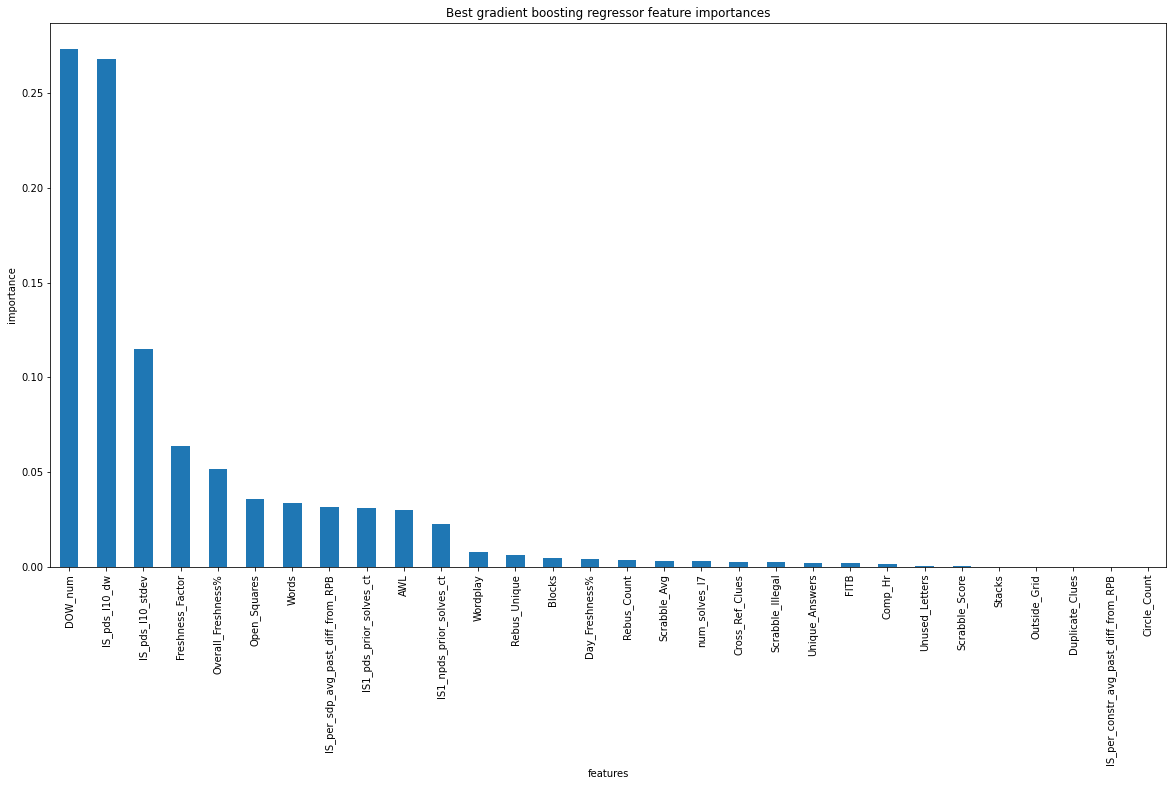

In [86]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
gb_feat_imps.nlargest(30).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

In [45]:
# Export out features and feature importances for full documentation csv
X_train.columns
gb_feat_imps.to_csv('../data/processed_data/gb_feat_imps.csv', index=True)

Index(['t_ind', 't_alt', 't_draw_sz', 't_lvl', 'm_bestof', 'm_rd_num', 'p_ent',
       'p_age', 't_1st_sv_in%_ratio', 't_1st_sv_in%_yielded_ratio',
       ...
       'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff',
       'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff',
       'p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff',
       'p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff',
       'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff',
       'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff',
       'p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff',
       'p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff',
       'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff',
       'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff'],
      dtype='object', length=367)

### Data Quality Assessment

Because Gradient Boosting Regressor turned out to be the best of the four models tested (in terms of cross-validation RMSE), a Data Quality Assessment was run on this model to ensure that results are not hindered by sample size.

In [593]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(GB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

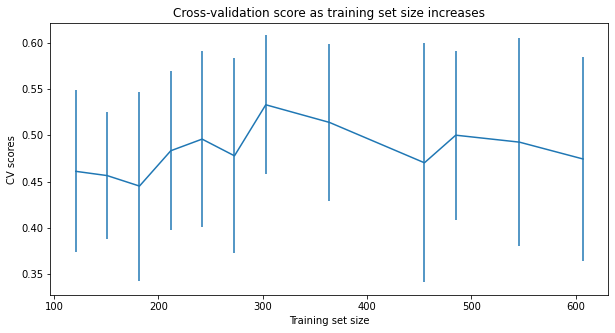

In [594]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

Best GBM Model RMSE Train/Test and Best Hyperparameters
(3.8489901698904703, 0.6556890805522403), 4.196379117943926

{'gradientboostingregressor__n_estimators': [100],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'gradientboostingregressor__learning_rate': [0.03],
 'gradientboostingregressor__max_depth': [2],
 'gradientboostingregressor__max_features': [9]}

## HistGradientBoosting Model

### Pipeline Creation

In [87]:
#Define pipeline
HGB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    HistGradientBoostingRegressor(random_state= 47)
)

In [88]:
HGB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'histgradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learning_rate', 'histgradientboostingregressor__loss', 'histgradientboostingregressor__max_bins', 'histgradientboostingregressor__max_depth', 'histgradientboostingregressor__max_iter', 'histgradientboostingregressor__max_leaf_nodes', 'histgradientboostingregressor__min_samples_leaf', 'histgradientboostingregressor__monotonic_cst', 'histgradientboostingregressor__n_iter_no_change', 'histgradientboostingregressor__random_state', 'histgradientboosting

### Hyperparameter  Grid Search and Model Fit Using Best Parameters from Grid Search

In [89]:
#Define grid search parameters

learning_rate = [.035]
max_iterations = [130]
max_depth = [4]

grid_params = {
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean', 'median'],
        'histgradientboostingregressor__learning_rate': learning_rate,
        'histgradientboostingregressor__max_iter': max_iterations,
        'histgradientboostingregressor__max_depth': max_depth
}
grid_params

{'standardscaler': [None],
 'simpleimputer__strategy': ['mean', 'median'],
 'histgradientboostingregressor__learning_rate': [0.035],
 'histgradientboostingregressor__max_iter': [130],
 'histgradientboostingregressor__max_depth': [4]}

In [90]:
#First Pass
# {'standardscaler': [None],
#  'simpleimputer__strategy': ['mean', 'median'], mean
#  'histgradientboostingregressor__learning_rate': [0.03, 0.04, 0.05], .04 (.035 won on refining passes)
#  'histgradientboostingregressor__max_iter': [110, 120, 130], 130 (125 won on refining passes)
#  'histgradientboostingregressor__max_depth': [3, 4, 5]} 4

In [91]:
#Call `GridSearchCV` with the hist gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation.
hgb_grid_cv = GridSearchCV(HGB_pipe, param_grid=grid_params, cv=5)

In [92]:
#`GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. 
hgb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor(random_state=47))]),
             param_grid={'histgradientboostingregressor__learning_rate': [0.035],
                         'histgradientboostingregressor__max_depth': [4],
                         'histgradientboostingregressor__max_iter': [130],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [None]})

In [93]:
#Best params (`best_params_` attribute) from the grid search    
hgb_grid_cv.best_params_

{'histgradientboostingregressor__learning_rate': 0.035,
 'histgradientboostingregressor__max_depth': 4,
 'histgradientboostingregressor__max_iter': 130,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Model Cross-Validation and Fit Metrics

#### R-Squared (Training Cross Validation, then Testing)

In [94]:
#Cross-validation defaults to R^2 metric for scoring regression
hgb_best_cv_results = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, cv=5)
hgb_best_scores = hgb_best_cv_results['test_score']
hgb_best_scores

array([0.55101413, 0.55667798, 0.6717536 , 0.48518763, 0.53863906])

In [95]:
#Training set CV mean and std
np.mean(hgb_best_scores), np.std(hgb_best_scores)

(0.5606544825942035, 0.061043735716166)

#### Mean Absolute Error (MAE)

In [96]:
hgb_neg_mae = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [97]:
#Training set CV mean and std
hgb_mae_mean = np.mean(-1 * hgb_neg_mae['test_score'])
hgb_mae_std = np.std(-1 * hgb_neg_mae['test_score'])
hgb_mae_mean, hgb_mae_std

(2.532587715986139, 0.35894682899594643)

In [98]:
# Test set mean
mean_absolute_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

2.4645973682370697

#### Mean Squared Error (MSE)

In [99]:
hgb_neg_mse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv= 5)

In [100]:
#Training set CV mean and std
hgb_mse_mean = np.mean(-1 * hgb_neg_mse['test_score'])
hgb_mse_std = np.std(-1 * hgb_neg_mse['test_score'])
hgb_mse_mean, hgb_mse_std

(15.727549854659344, 5.877388585608251)

In [101]:
# Test set mean
mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

15.24157650462435

#### Root Mean Squred Error (RMSE)

In [102]:
hgb_neg_rmse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [103]:
#Training set CV mean and std
hgb_rmse_mean = np.mean(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_std = np.std(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_mean, hgb_rmse_std

(3.889751883688652, 0.772903705515718)

In [104]:
# Test set mean
np.sqrt(mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test)))

3.9040461709134986

Hist Gradient Boosting Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)

(3.8040682841475246, 0.643159296723156), 4.074649288321549

{'histgradientboostingregressor__learning_rate': 0.035,
 'histgradientboostingregressor__max_depth': 4,
 'histgradientboostingregressor__max_iter': 125,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

## Save Best Model Object From Pipeline (Linear Model)

The Linear Model turned out to be the best of the four models tested (based on cross-validation RMSE). Below, the best model is saved to be run on the full dataset in a final step ().  

In [659]:
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [660]:
# save the model
modelpath = '../models'
save_file(best_model, 'IS1_model.pkl', modelpath)

Writing file.  "../models\IS1_model.pkl"


## Conclusions
